<a href="https://colab.research.google.com/github/MohammadAghaei1/Generative-AI/blob/main/GANs_%26_VAEs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Libraries**

In [1]:
import time
import torch
import numpy as np
import tensorflow as tf
from scipy.linalg import sqrtm
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input

# **DCGAN**

### **Loading dataset**

In [2]:
# LOAD AND PREPROCESS DATA
print("Loading MNIST data...")
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()

# Reshape from (60000, 28, 28) → (60000, 28, 28, 1)
# Add channel dimension for Conv2D (1 = grayscale)
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')

Loading MNIST data...
11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


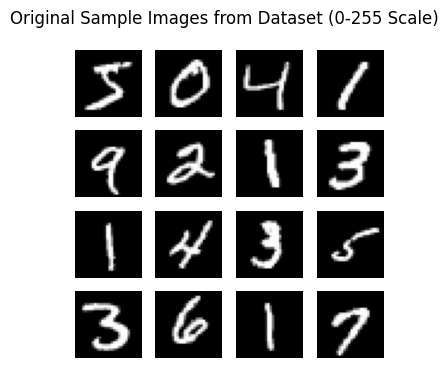

In [3]:
# Load a small sample of original MNIST images to avoid re-normalizing the main dataset
(original_display_images, _), (_, _) = tf.keras.datasets.mnist.load_data()

# Take the first 16 images for display and reshape them
original_display_images = original_display_images[:16].reshape(-1, 28, 28, 1)

plt.figure(figsize=(4, 4))
for i in range(original_display_images.shape[0]):
    plt.subplot(4, 4, i + 1)
    # Display images directly in their original [0, 255] scale
    plt.imshow(original_display_images[i, :, :, 0], cmap='gray', vmin=0, vmax=255)
    plt.axis('off')
plt.suptitle('Original Sample Images from Dataset (0-255 Scale)')
plt.show()

In [4]:
# Normalize pixel values from [0, 255] → [-1, 1]
train_images = (train_images - 127.5) / 127.5

# Check the shape of the data
print(train_images.shape)

# Dataset parameters
BUFFER_SIZE = 60000
BATCH_SIZE = 128

#  - shuffle it
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE)

(60000, 28, 28, 1)


In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cuda


## **Making Generator**

In [6]:
def make_generator_model(noise_dim):
    model = tf.keras.Sequential()

    # Input: Random Noise
    # # Start with a dense layer that outputs a 7x7x128 tensor
    model.add(layers.Dense(7*7*128, use_bias=False, input_shape=(noise_dim,)))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((7, 7, 128)))

    # Upsample from 7x7 to 14x14
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU())

    # Upsample from 14x14 to 28x28
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization(momentum=0.8))  #
    model.add(layers.LeakyReLU())

    # Refine 28x28 (Stride = 1)
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))

    model.summary()

    return model

In [7]:
NOISE_DIM = 100
generator = make_generator_model(NOISE_DIM)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 6272)           │       627,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 6272)           │        25,088 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 128)    │       409,600 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 64)     │       204,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 28, 28, 1)      │         1,600 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,269,056 (4.84 MB)

 Trainable params: 1,256,128 (4.79 MB)

 Non-trainable params: 12,928 (50.50 KB)

## **Making Discriminator**

In [8]:
def make_discriminator_model():
    model = tf.keras.Sequential()

    # --- Block 1: 32 Filters (Input) ---
    # Matches Code A: Conv2D(32) -> LeakyReLU -> Dropout
    model.add(layers.Conv2D(32, kernel_size=3, strides=2, padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))

    # --- Block 2: 64 Filters ---
    # Matches Code A: Conv2D(64) -> BN -> LeakyReLU -> Dropout
    model.add(layers.Conv2D(64, kernel_size=3, strides=2, padding='same'))
    # Note: I used padding='same' instead of manual ZeroPadding2D to prevent shape errors
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))

    # --- Block 3: 128 Filters ---
    # Matches Code A: Conv2D(128) -> BN -> LeakyReLU -> Dropout
    model.add(layers.Conv2D(128, kernel_size=3, strides=2, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))

    # --- Block 4: 256 Filters ---
    # Matches Code A: Conv2D(256) -> BN -> LeakyReLU -> Dropout
    # Note: Strides=1 here (just like Code A) to refine features without shrinking size
    model.add(layers.Conv2D(256, kernel_size=3, strides=1, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))

    # --- Output ---
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))

    model.summary()

    return model

In [9]:
discriminator = make_discriminator_model()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 14, 14, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 7, 7, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         4,097 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 393,729 (1.50 MB)

 Trainable params: 392,833 (1.50 MB)

 Non-trainable params: 896 (3.50 KB)

## **Loss functions and optimizers**

In [10]:
# Binary cross-entropy loss for real/fake classification
# from_logits=False because discriminator uses sigmoid
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

def discriminator_loss(real_output, fake_output):
    """
    real_output: D(real images)  -> should be close to 1
    fake_output: D(fake images)  -> should be close to 0
    """
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)   # label 1 for real
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)  # label 0 for fake
    return real_loss + fake_loss

def generator_loss(fake_output):
    """
    fake_output: D(fake images)
    Generator wants D(fake) ≈ 1 (fool the discriminator)
    """
    return cross_entropy(tf.ones_like(fake_output), fake_output)  # want label 1 for fake


In [11]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)

## **Making DCGAN**

In [12]:
@tf.function
def train_step(images):

    # Sample random noise for the generator: (batch_size, NOISE_DIM)
    # Here batch_size is fixed to 128, matching BATCH_SIZE
    noise = tf.random.normal([128, NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate fake images from noise
        generated_images = generator(noise, training=True)

        # Discriminator output for real and fake images
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        # Compute losses
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    # Compute gradients
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Apply gradients (update weights)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    # ----- Discriminator accuracies -----
    # Real images: correct if prediction > 0.5 (classified as real)
    real_pred = tf.cast(real_output > 0.5, tf.float32)
    real_acc = tf.reduce_mean(real_pred)  # fraction of real images correctly classified

    # Fake images: correct if prediction <= 0.5 (classified as fake)
    fake_pred_real = tf.cast(fake_output > 0.5, tf.float32)  # 1 if predicted real (wrong)
    fake_acc = tf.reduce_mean(1.0 - fake_pred_real)          # 1 - wrong = correct

    return gen_loss, disc_loss, real_acc, fake_acc


**Function for saving and plotting images**

In [13]:
def generate_and_save_images(model, epoch, test_input):
    """
    Generate images from a fixed noise vector (test_input)
    and plot them in a 4x4 grid.
    """
    # Disable training behavior (e.g., batchnorm updates)
    predictions = model(test_input, training=False)

    plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)

        # Convert from [-1, 1] back to [0, 1] for display
        img_to_plot = (predictions[i, :, :, 0] + 1) / 2.0

        plt.imshow(img_to_plot, cmap='gray')
        plt.axis('off')

    plt.suptitle(f'Epoch {epoch}')
    plt.show()

## **Training**

In [14]:
# Initialize lists to store metrics for each epoch
gen_loss_history = []
disc_loss_history = []
real_acc_history = []
fake_acc_history = []

# Modify the train function to save the metrics
def train(dataset, epochs):
    print("Starting training with Tanh [-1, 1]...")

    # Batch the dataset here (we kept it unbatched before)
    BATCH_SIZE = 128
    dataset = dataset.batch(BATCH_SIZE)

    for epoch in range(epochs):
        g_loss_metric = 0.0
        d_loss_metric = 0.0
        real_acc_metric = 0.0
        fake_acc_metric = 0.0
        steps = 0

        # Iterate over all batches in the dataset
        for image_batch in dataset:
            g_loss, d_loss, real_acc, fake_acc = train_step(image_batch)
            g_loss_metric += g_loss
            d_loss_metric += d_loss
            real_acc_metric += real_acc
            fake_acc_metric += fake_acc
            steps += 1

        # Average over all batches (epoch metrics)
        avg_g_loss = g_loss_metric / steps
        avg_d_loss = d_loss_metric / steps
        avg_real_acc = real_acc_metric / steps
        avg_fake_acc = fake_acc_metric / steps

        # Store the metrics for plotting
        gen_loss_history.append(avg_g_loss)
        disc_loss_history.append(avg_d_loss)
        real_acc_history.append(avg_real_acc)
        fake_acc_history.append(avg_fake_acc)

        # Print losses + discriminator accuracies (in %)
        print(
            f'Epoch {epoch + 1}, '
            f'Gen Loss: {avg_g_loss:.4f}, '
            f'Disc Loss: {avg_d_loss:.4f}, '
            f'D(real)%: {avg_real_acc * 100:.1f}, '
            f'D(fake)%: {avg_fake_acc * 100:.1f}'
        )

        # Visualize 16 generated images from a fixed noise vector
        generate_and_save_images(generator, epoch + 1, seed)

**Running DCGAN**

Starting training with Tanh [-1, 1]...
Epoch 1, Gen Loss: 0.9987, Disc Loss: 1.2940, D(real)%: 63.5, D(fake)%: 63.3


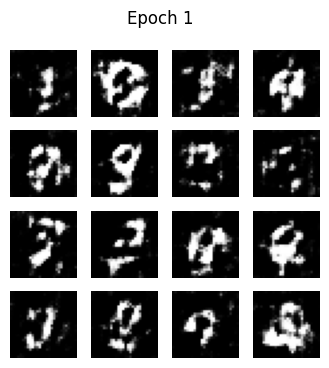

Epoch 2, Gen Loss: 1.0639, Disc Loss: 1.1535, D(real)%: 69.6, D(fake)%: 69.4


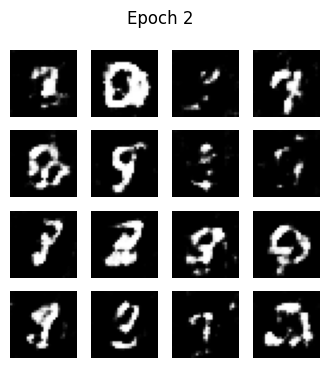

Epoch 3, Gen Loss: 1.4127, Disc Loss: 0.9550, D(real)%: 77.0, D(fake)%: 77.6


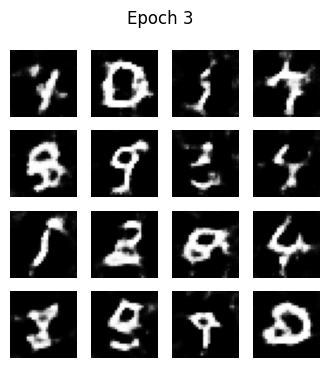

Epoch 4, Gen Loss: 1.2224, Disc Loss: 1.0668, D(real)%: 73.0, D(fake)%: 73.6


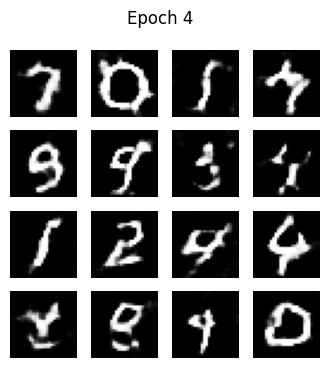

Epoch 5, Gen Loss: 1.2685, Disc Loss: 1.0062, D(real)%: 75.7, D(fake)%: 76.1


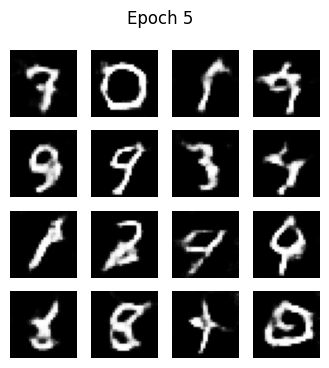

Epoch 6, Gen Loss: 1.3257, Disc Loss: 0.9532, D(real)%: 77.5, D(fake)%: 78.0


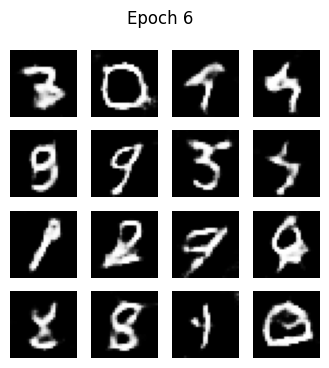

Epoch 7, Gen Loss: 1.4035, Disc Loss: 0.8989, D(real)%: 79.7, D(fake)%: 79.8


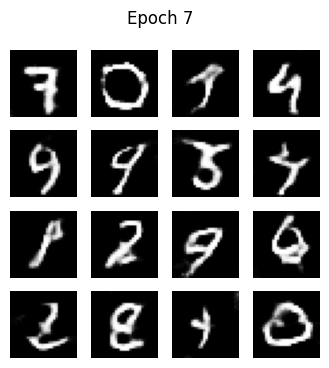

Epoch 8, Gen Loss: 1.4574, Disc Loss: 0.8721, D(real)%: 80.4, D(fake)%: 80.5


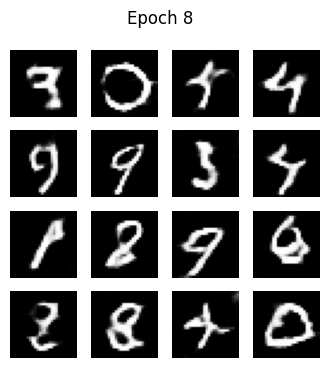

Epoch 9, Gen Loss: 1.5086, Disc Loss: 0.8427, D(real)%: 81.6, D(fake)%: 81.6


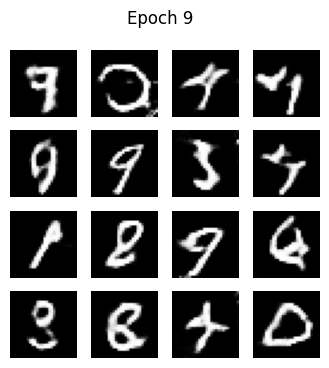

Epoch 10, Gen Loss: 1.5576, Disc Loss: 0.8211, D(real)%: 82.3, D(fake)%: 82.1


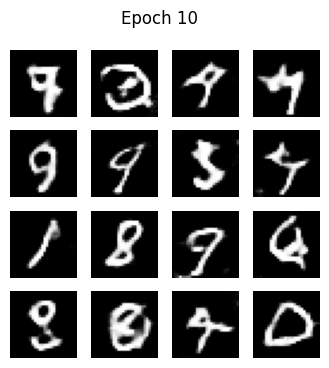

Epoch 11, Gen Loss: 1.6126, Disc Loss: 0.8020, D(real)%: 82.7, D(fake)%: 82.6


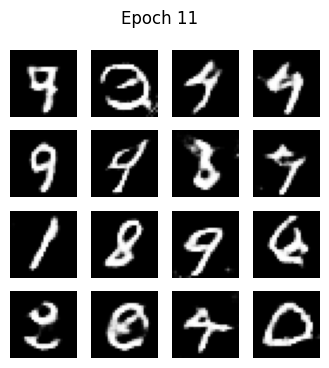

Epoch 12, Gen Loss: 1.6298, Disc Loss: 0.8020, D(real)%: 82.5, D(fake)%: 82.7


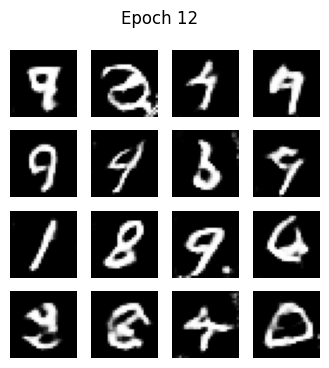

Epoch 13, Gen Loss: 1.6444, Disc Loss: 0.7944, D(real)%: 82.7, D(fake)%: 82.7


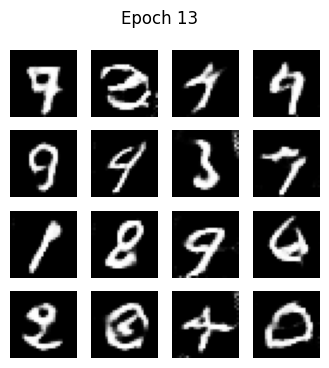

Epoch 14, Gen Loss: 1.6608, Disc Loss: 0.7979, D(real)%: 82.4, D(fake)%: 82.5


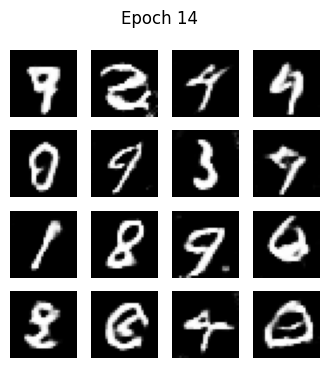

Epoch 15, Gen Loss: 1.6797, Disc Loss: 0.8238, D(real)%: 81.6, D(fake)%: 81.2


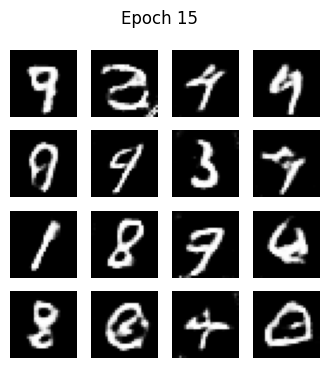

Epoch 16, Gen Loss: 1.6799, Disc Loss: 0.8185, D(real)%: 81.7, D(fake)%: 81.5


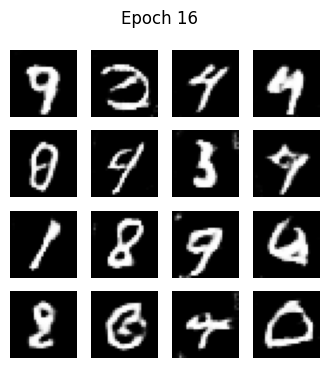

Epoch 17, Gen Loss: 1.6699, Disc Loss: 0.8281, D(real)%: 81.3, D(fake)%: 81.1


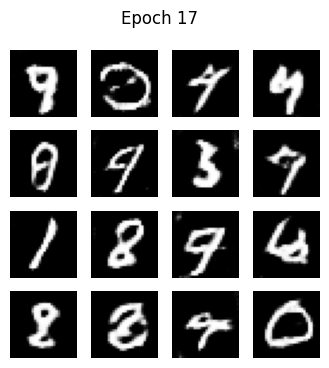

Epoch 18, Gen Loss: 1.6797, Disc Loss: 0.8279, D(real)%: 81.2, D(fake)%: 81.2


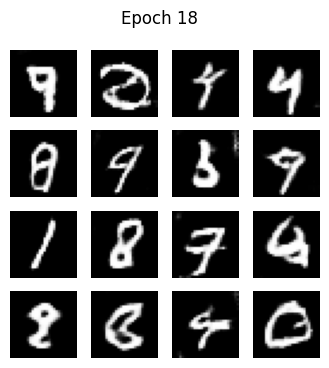

Epoch 19, Gen Loss: 1.6923, Disc Loss: 0.8160, D(real)%: 81.7, D(fake)%: 81.7


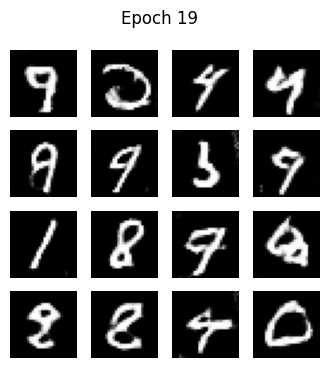

Epoch 20, Gen Loss: 1.6986, Disc Loss: 0.8091, D(real)%: 82.0, D(fake)%: 81.7


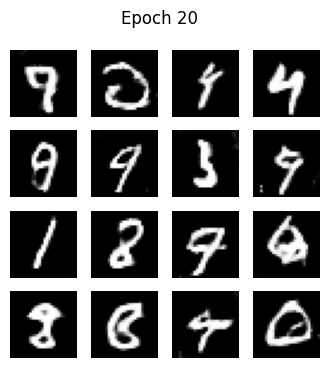

Epoch 21, Gen Loss: 1.6990, Disc Loss: 0.8452, D(real)%: 81.1, D(fake)%: 80.4


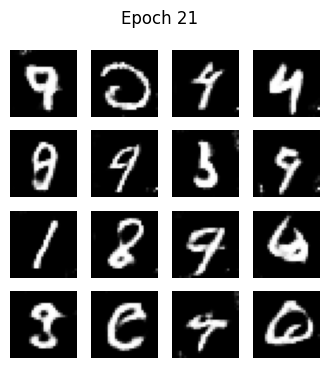

Epoch 22, Gen Loss: 1.6903, Disc Loss: 0.8542, D(real)%: 80.3, D(fake)%: 80.1


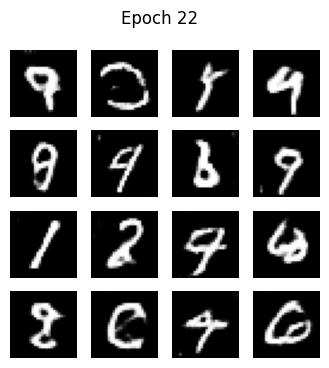

Epoch 23, Gen Loss: 1.6766, Disc Loss: 0.8607, D(real)%: 80.1, D(fake)%: 79.9


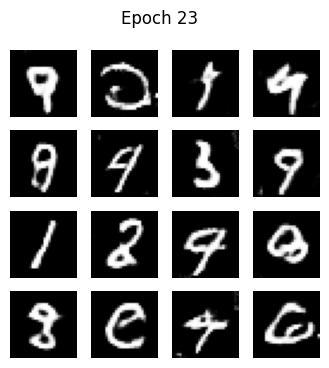

Epoch 24, Gen Loss: 1.6924, Disc Loss: 0.8423, D(real)%: 80.9, D(fake)%: 80.8


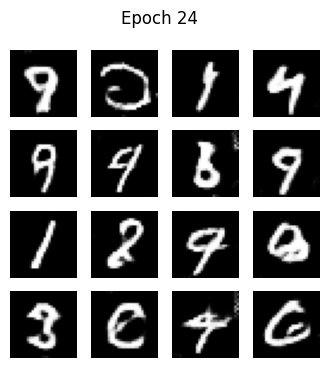

Epoch 25, Gen Loss: 1.7030, Disc Loss: 0.8430, D(real)%: 80.8, D(fake)%: 80.4


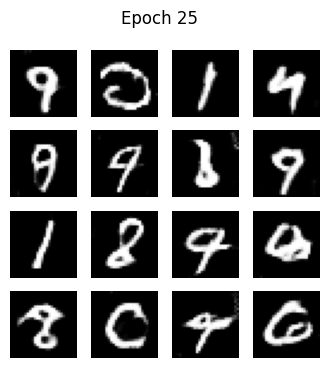

Epoch 26, Gen Loss: 1.7298, Disc Loss: 0.8474, D(real)%: 80.6, D(fake)%: 80.1


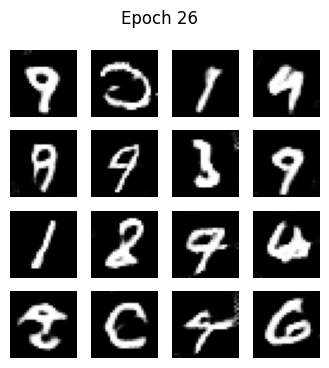

Epoch 27, Gen Loss: 1.7030, Disc Loss: 0.8425, D(real)%: 80.6, D(fake)%: 80.8


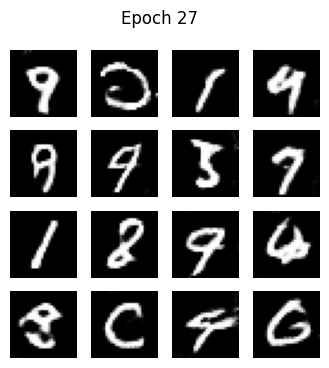

Epoch 28, Gen Loss: 1.7448, Disc Loss: 0.8272, D(real)%: 81.3, D(fake)%: 80.9


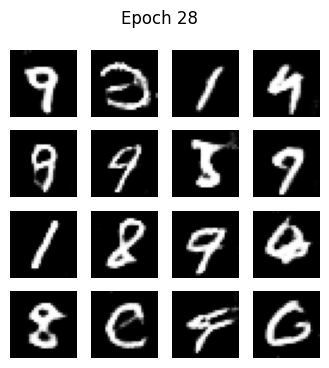

Epoch 29, Gen Loss: 1.7299, Disc Loss: 0.8619, D(real)%: 80.3, D(fake)%: 79.9


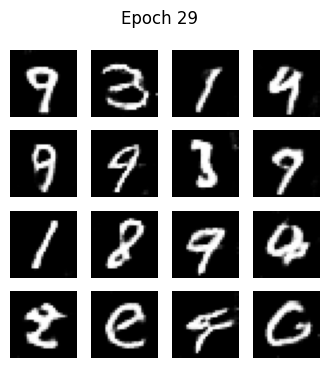

Epoch 30, Gen Loss: 1.7142, Disc Loss: 0.8759, D(real)%: 79.8, D(fake)%: 79.4


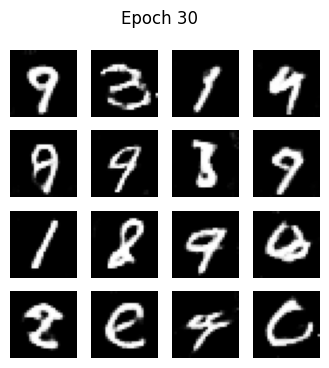

Epoch 31, Gen Loss: 1.7150, Disc Loss: 0.8633, D(real)%: 80.2, D(fake)%: 79.6


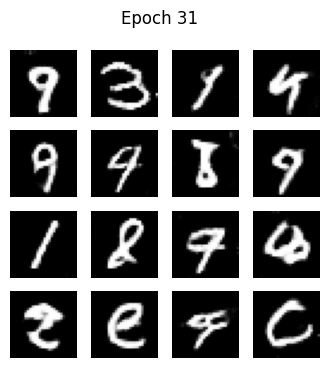

Epoch 32, Gen Loss: 1.7499, Disc Loss: 0.8433, D(real)%: 80.6, D(fake)%: 80.4


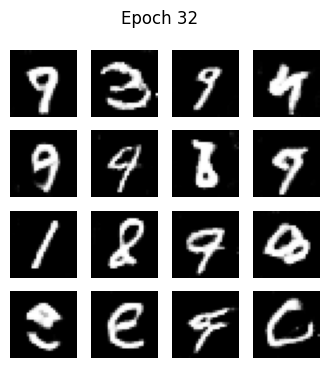

Epoch 33, Gen Loss: 1.6967, Disc Loss: 0.8692, D(real)%: 79.8, D(fake)%: 80.0


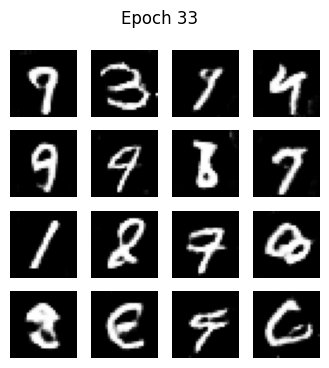

Epoch 34, Gen Loss: 1.7203, Disc Loss: 0.8643, D(real)%: 80.0, D(fake)%: 80.0


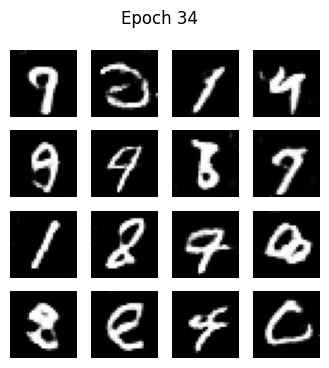

Epoch 35, Gen Loss: 1.7002, Disc Loss: 0.8762, D(real)%: 79.5, D(fake)%: 79.6


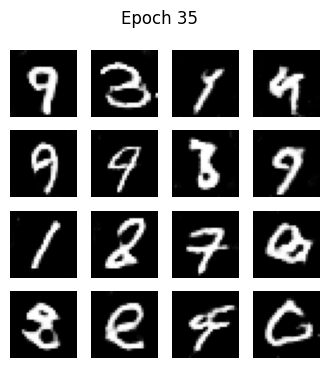

Epoch 36, Gen Loss: 1.7098, Disc Loss: 0.8719, D(real)%: 79.9, D(fake)%: 79.8


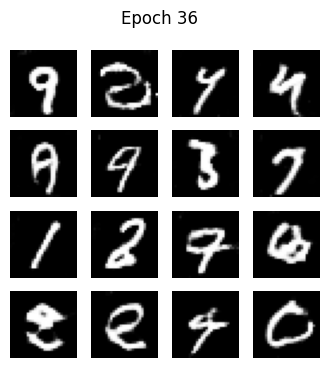

Epoch 37, Gen Loss: 1.7397, Disc Loss: 0.8418, D(real)%: 80.8, D(fake)%: 80.6


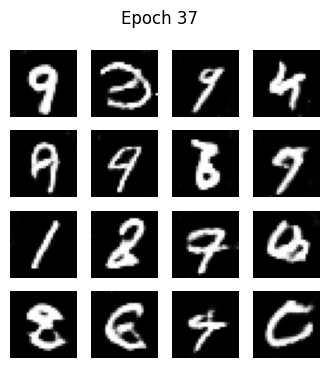

Epoch 38, Gen Loss: 1.7339, Disc Loss: 0.8649, D(real)%: 80.2, D(fake)%: 80.1


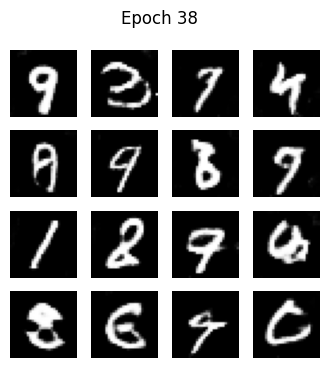

Epoch 39, Gen Loss: 1.7286, Disc Loss: 0.8783, D(real)%: 79.6, D(fake)%: 79.5


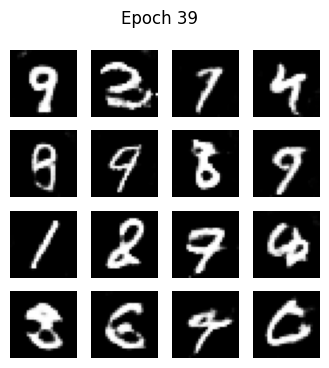

Epoch 40, Gen Loss: 1.7426, Disc Loss: 0.8434, D(real)%: 80.5, D(fake)%: 80.7


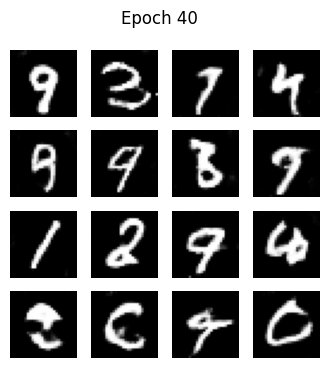

Epoch 41, Gen Loss: 1.7301, Disc Loss: 0.8789, D(real)%: 79.9, D(fake)%: 79.6


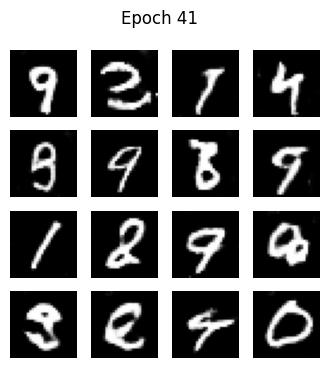

Epoch 42, Gen Loss: 1.7414, Disc Loss: 0.8663, D(real)%: 80.2, D(fake)%: 79.6


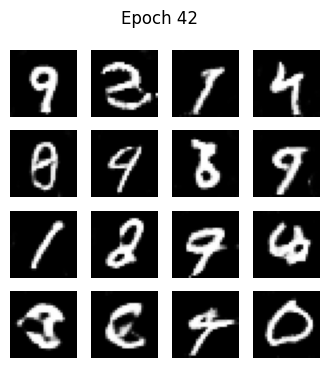

Epoch 43, Gen Loss: 1.7145, Disc Loss: 0.8771, D(real)%: 79.6, D(fake)%: 79.5


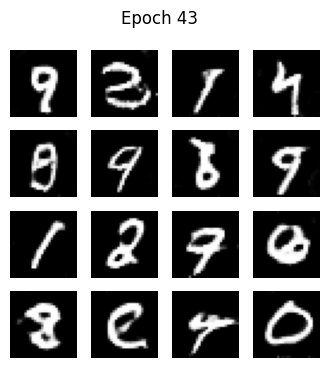

Epoch 44, Gen Loss: 1.7029, Disc Loss: 0.8877, D(real)%: 79.4, D(fake)%: 79.1


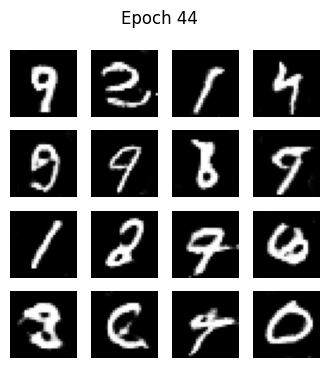

Epoch 45, Gen Loss: 1.7464, Disc Loss: 0.8505, D(real)%: 80.4, D(fake)%: 80.0


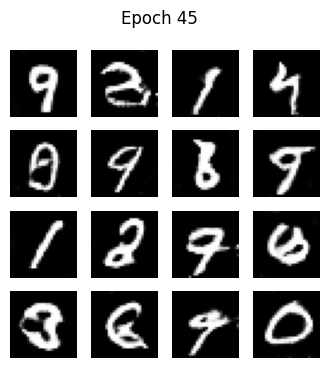

Epoch 46, Gen Loss: 1.7316, Disc Loss: 0.8843, D(real)%: 79.5, D(fake)%: 79.0


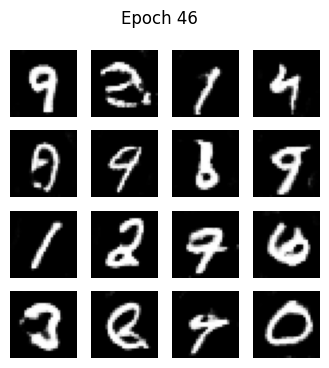

Epoch 47, Gen Loss: 1.7331, Disc Loss: 0.8742, D(real)%: 79.7, D(fake)%: 79.2


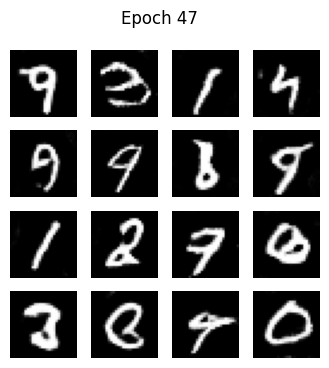

Epoch 48, Gen Loss: 1.7238, Disc Loss: 0.8891, D(real)%: 79.0, D(fake)%: 79.3


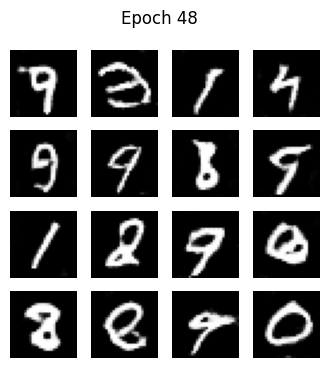

Epoch 49, Gen Loss: 1.7686, Disc Loss: 0.8613, D(real)%: 79.8, D(fake)%: 79.8


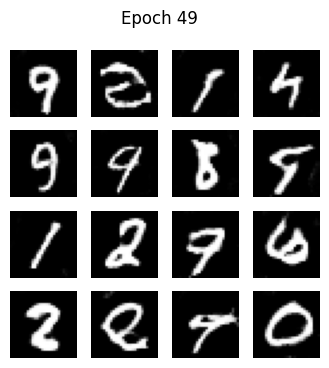

Epoch 50, Gen Loss: 1.7507, Disc Loss: 0.8745, D(real)%: 79.7, D(fake)%: 79.5


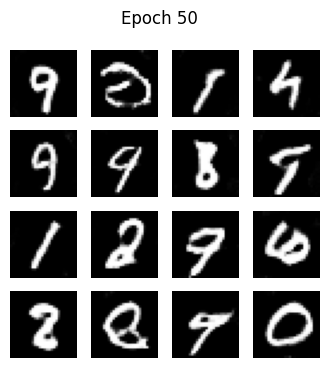

Epoch 51, Gen Loss: 1.7552, Disc Loss: 0.8421, D(real)%: 80.5, D(fake)%: 80.4


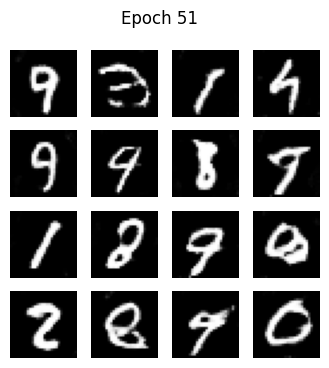

Epoch 52, Gen Loss: 1.7351, Disc Loss: 0.8901, D(real)%: 79.1, D(fake)%: 79.0


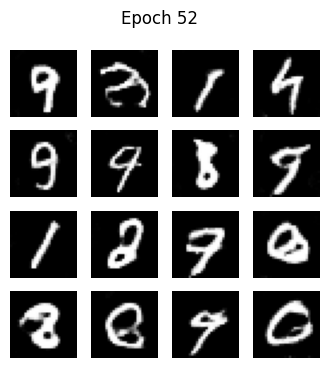

Epoch 53, Gen Loss: 1.7505, Disc Loss: 0.8611, D(real)%: 80.3, D(fake)%: 79.6


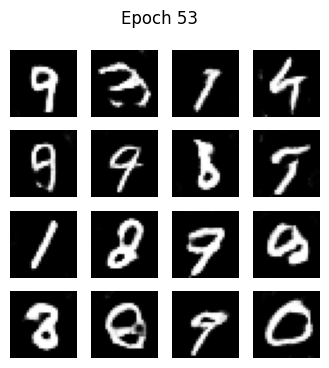

Epoch 54, Gen Loss: 1.7778, Disc Loss: 0.8597, D(real)%: 80.2, D(fake)%: 79.7


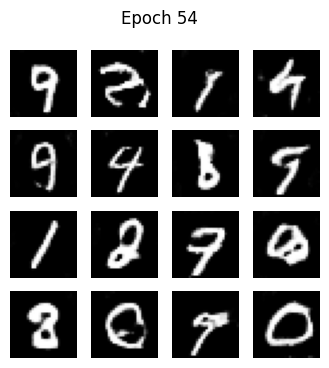

Epoch 55, Gen Loss: 1.7359, Disc Loss: 0.8836, D(real)%: 79.2, D(fake)%: 79.1


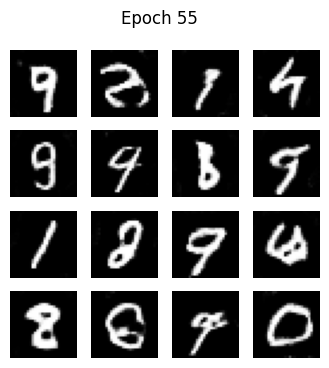

Epoch 56, Gen Loss: 1.8015, Disc Loss: 0.8425, D(real)%: 80.4, D(fake)%: 80.4


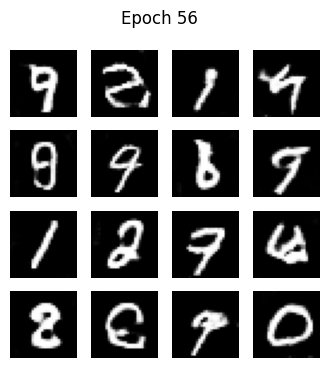

Epoch 57, Gen Loss: 1.8038, Disc Loss: 0.8681, D(real)%: 79.9, D(fake)%: 79.7


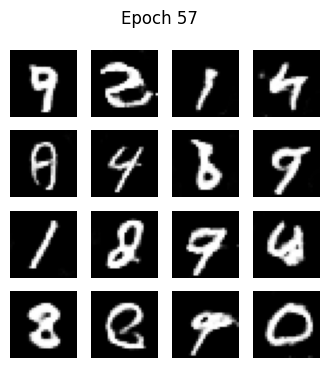

Epoch 58, Gen Loss: 1.7850, Disc Loss: 0.8454, D(real)%: 80.3, D(fake)%: 80.2


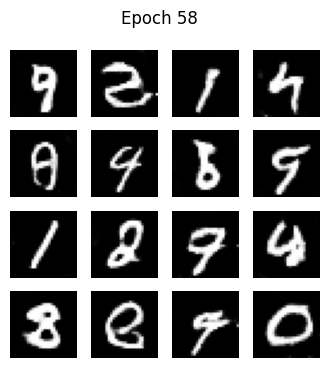

Epoch 59, Gen Loss: 1.7627, Disc Loss: 0.8856, D(real)%: 79.3, D(fake)%: 78.7


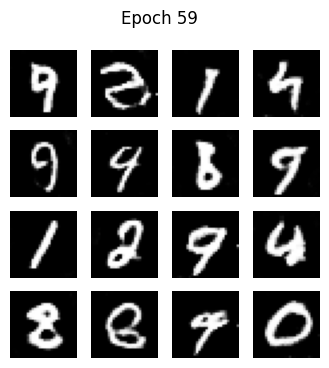

Epoch 60, Gen Loss: 1.7985, Disc Loss: 0.8590, D(real)%: 80.1, D(fake)%: 79.7


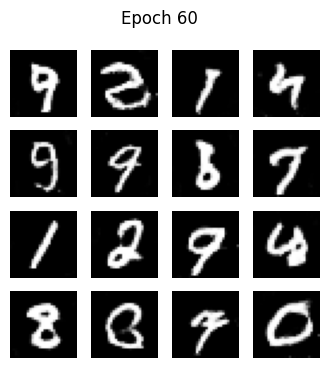

Epoch 61, Gen Loss: 1.7575, Disc Loss: 0.8661, D(real)%: 79.8, D(fake)%: 79.6


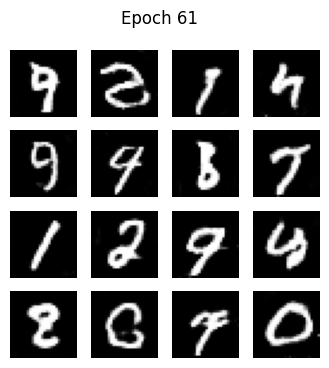

Epoch 62, Gen Loss: 1.7778, Disc Loss: 0.8870, D(real)%: 79.2, D(fake)%: 79.3


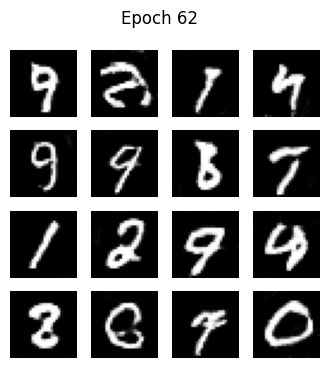

Epoch 63, Gen Loss: 1.7782, Disc Loss: 0.8603, D(real)%: 80.0, D(fake)%: 79.8


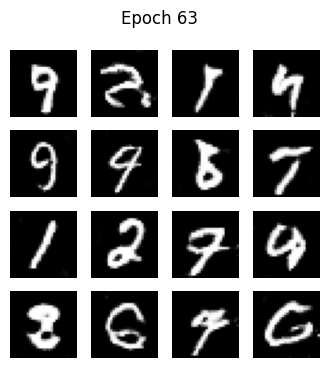

Epoch 64, Gen Loss: 1.7785, Disc Loss: 0.8455, D(real)%: 80.2, D(fake)%: 80.5


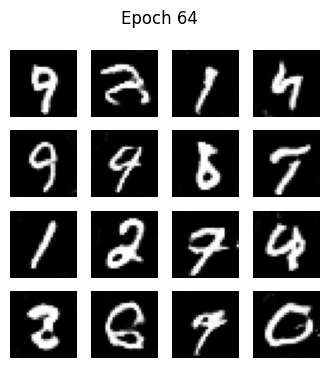

Epoch 65, Gen Loss: 1.7714, Disc Loss: 0.8789, D(real)%: 79.8, D(fake)%: 79.0


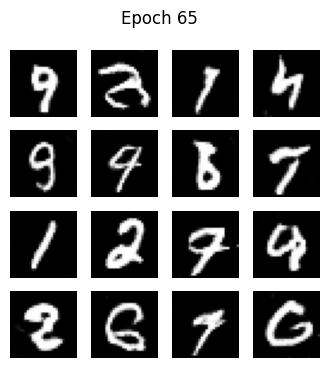

Epoch 66, Gen Loss: 1.7507, Disc Loss: 0.8716, D(real)%: 79.6, D(fake)%: 79.6


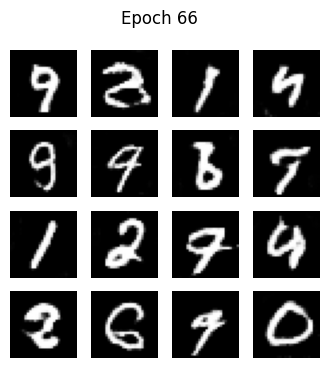

Epoch 67, Gen Loss: 1.8042, Disc Loss: 0.8532, D(real)%: 80.3, D(fake)%: 79.8


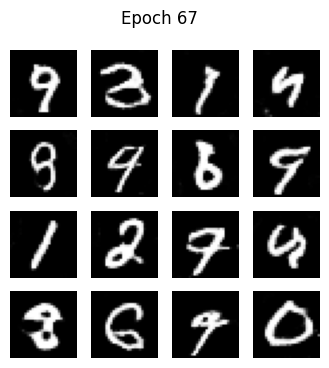

Epoch 68, Gen Loss: 1.7824, Disc Loss: 0.8802, D(real)%: 79.8, D(fake)%: 79.1


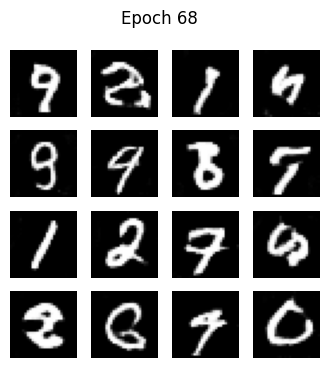

Epoch 69, Gen Loss: 1.7923, Disc Loss: 0.8613, D(real)%: 80.0, D(fake)%: 79.8


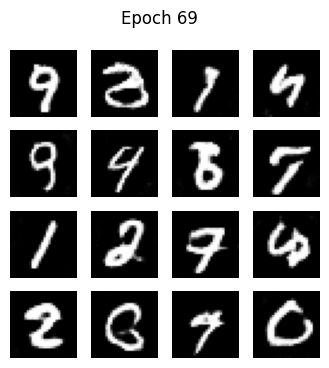

Epoch 70, Gen Loss: 1.7875, Disc Loss: 0.8639, D(real)%: 80.0, D(fake)%: 79.8


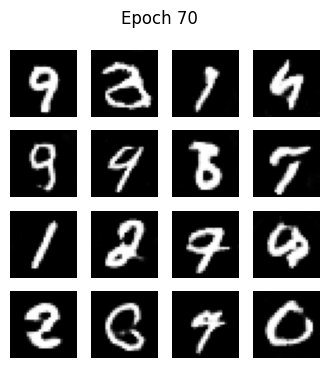

Epoch 71, Gen Loss: 1.8054, Disc Loss: 0.8741, D(real)%: 79.8, D(fake)%: 79.1


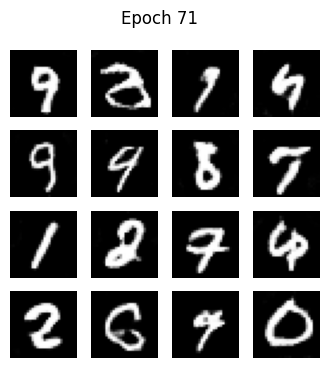

Epoch 72, Gen Loss: 1.7719, Disc Loss: 0.8645, D(real)%: 80.0, D(fake)%: 79.8


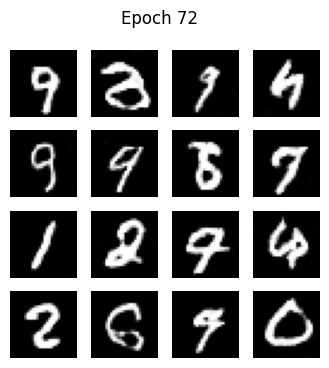

Epoch 73, Gen Loss: 1.7786, Disc Loss: 0.8804, D(real)%: 79.5, D(fake)%: 79.0


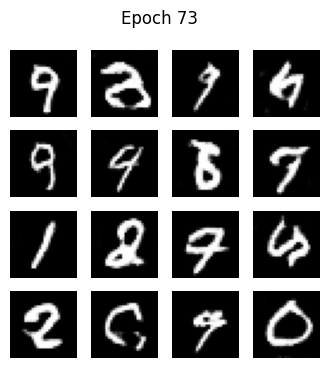

Epoch 74, Gen Loss: 1.7429, Disc Loss: 0.8730, D(real)%: 79.5, D(fake)%: 79.6


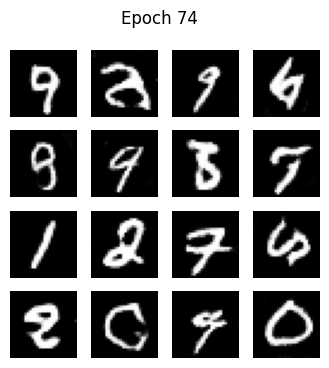

Epoch 75, Gen Loss: 1.7935, Disc Loss: 0.8561, D(real)%: 80.0, D(fake)%: 80.1


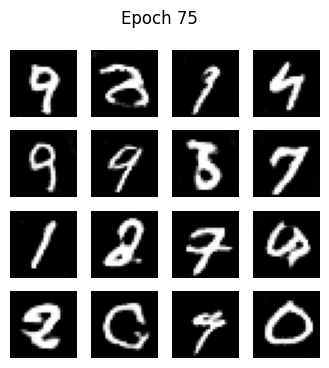

Epoch 76, Gen Loss: 1.7896, Disc Loss: 0.8523, D(real)%: 80.1, D(fake)%: 80.2


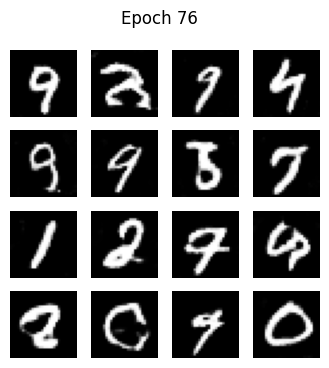

Epoch 77, Gen Loss: 1.8031, Disc Loss: 0.8476, D(real)%: 80.0, D(fake)%: 80.4


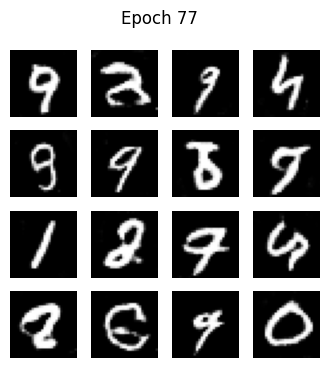

Epoch 78, Gen Loss: 1.7894, Disc Loss: 0.8843, D(real)%: 79.3, D(fake)%: 79.2


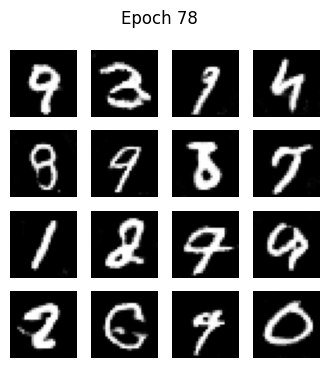

Epoch 79, Gen Loss: 1.8053, Disc Loss: 0.8481, D(real)%: 80.4, D(fake)%: 80.3


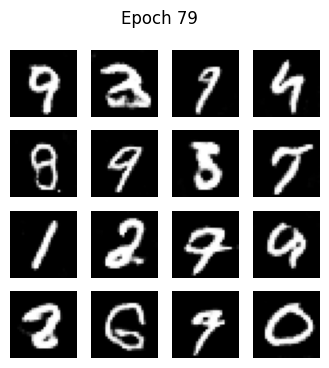

Epoch 80, Gen Loss: 1.7961, Disc Loss: 0.8780, D(real)%: 79.4, D(fake)%: 79.4


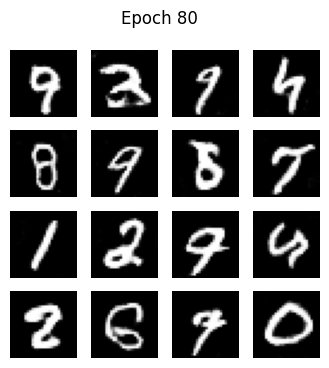

Epoch 81, Gen Loss: 1.8101, Disc Loss: 0.8492, D(real)%: 80.3, D(fake)%: 80.2


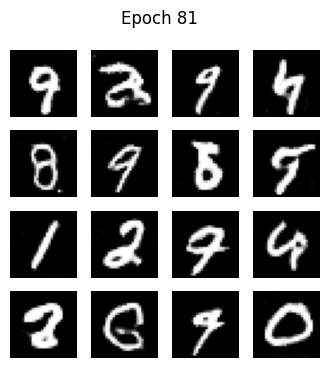

Epoch 82, Gen Loss: 1.8225, Disc Loss: 0.8660, D(real)%: 79.5, D(fake)%: 80.1


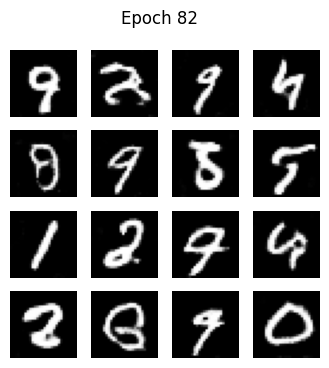

Epoch 83, Gen Loss: 1.7977, Disc Loss: 0.8720, D(real)%: 79.4, D(fake)%: 79.6


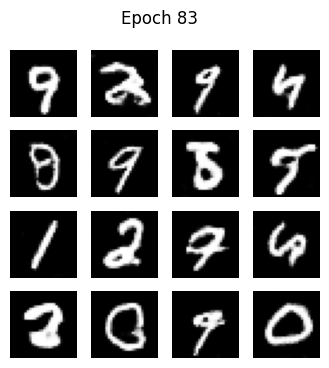

Epoch 84, Gen Loss: 1.8101, Disc Loss: 0.8609, D(real)%: 80.0, D(fake)%: 79.6


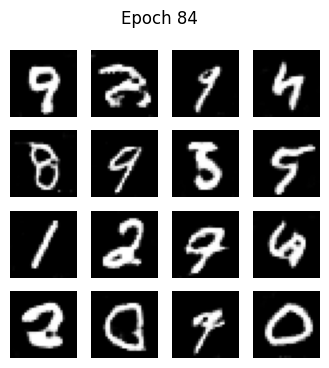

Epoch 85, Gen Loss: 1.7813, Disc Loss: 0.8965, D(real)%: 79.2, D(fake)%: 78.9


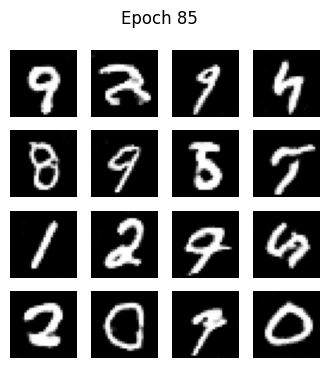

Epoch 86, Gen Loss: 1.7881, Disc Loss: 0.8743, D(real)%: 79.6, D(fake)%: 79.3


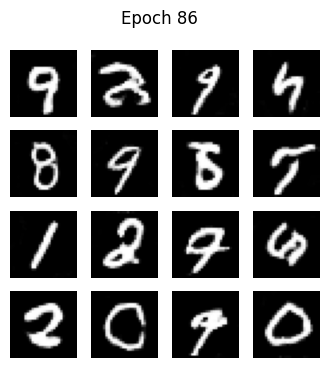

Epoch 87, Gen Loss: 1.7740, Disc Loss: 0.8709, D(real)%: 79.4, D(fake)%: 79.7


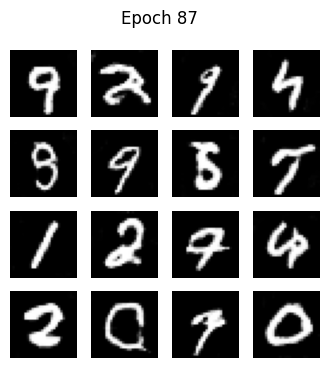

Epoch 88, Gen Loss: 1.7721, Disc Loss: 0.8808, D(real)%: 79.4, D(fake)%: 79.3


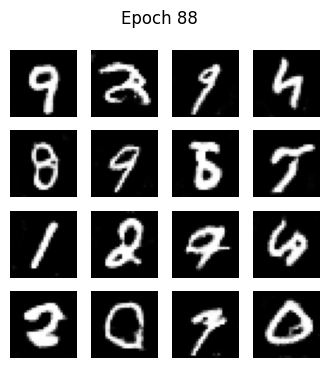

Epoch 89, Gen Loss: 1.7638, Disc Loss: 0.8894, D(real)%: 79.2, D(fake)%: 78.9


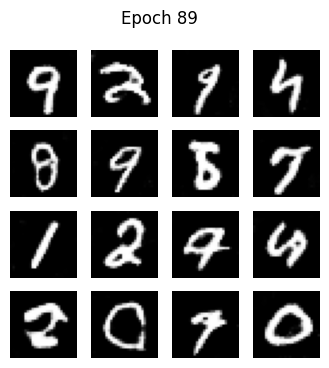

Epoch 90, Gen Loss: 1.7987, Disc Loss: 0.8581, D(real)%: 80.1, D(fake)%: 79.7


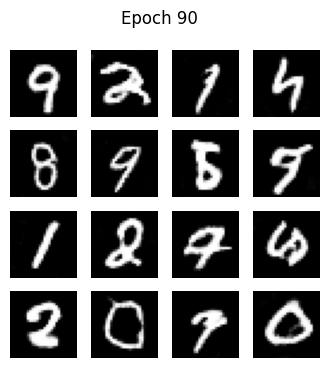

Epoch 91, Gen Loss: 1.7900, Disc Loss: 0.8726, D(real)%: 79.3, D(fake)%: 79.6


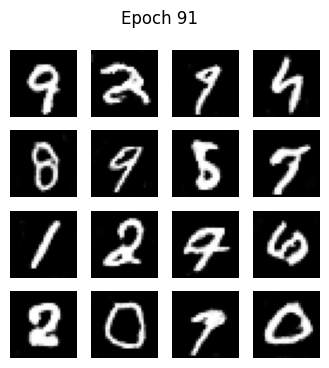

Epoch 92, Gen Loss: 1.8172, Disc Loss: 0.8598, D(real)%: 80.2, D(fake)%: 79.8


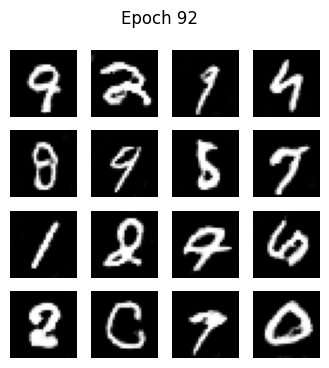

Epoch 93, Gen Loss: 1.7856, Disc Loss: 0.8625, D(real)%: 79.8, D(fake)%: 79.8


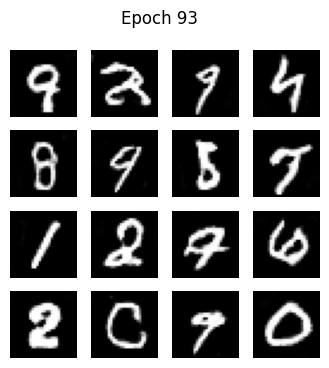

Epoch 94, Gen Loss: 1.8070, Disc Loss: 0.8667, D(real)%: 80.0, D(fake)%: 79.8


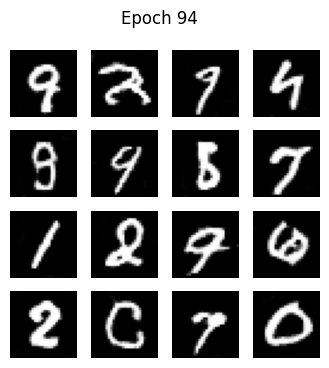

Epoch 95, Gen Loss: 1.7945, Disc Loss: 0.8697, D(real)%: 79.8, D(fake)%: 79.4


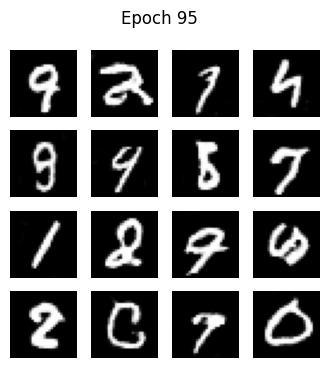

Epoch 96, Gen Loss: 1.8232, Disc Loss: 0.8716, D(real)%: 80.0, D(fake)%: 79.6


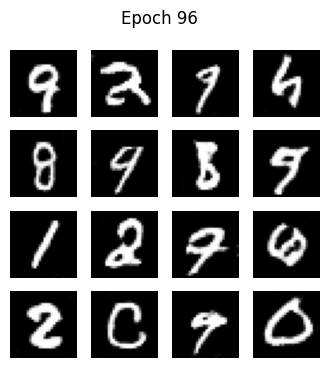

Epoch 97, Gen Loss: 1.7702, Disc Loss: 0.8853, D(real)%: 79.1, D(fake)%: 79.3


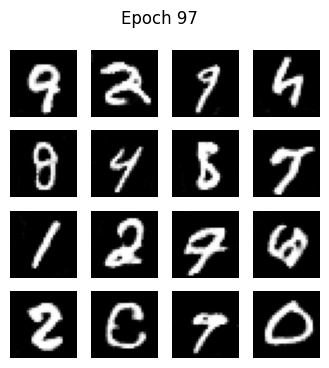

Epoch 98, Gen Loss: 1.7979, Disc Loss: 0.8717, D(real)%: 79.6, D(fake)%: 79.8


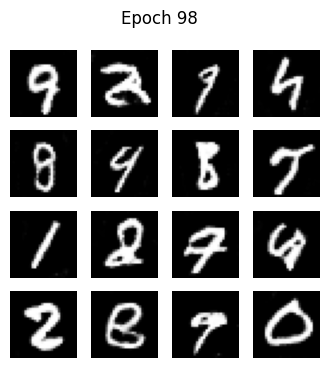

Epoch 99, Gen Loss: 1.7675, Disc Loss: 0.8906, D(real)%: 79.0, D(fake)%: 78.8


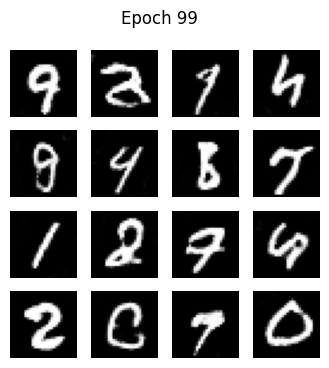

Epoch 100, Gen Loss: 1.7420, Disc Loss: 0.8999, D(real)%: 78.7, D(fake)%: 78.7


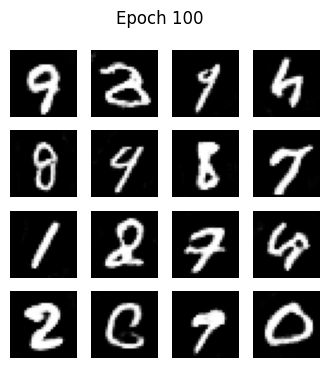

In [15]:
# Fixed noise vector used for monitoring generator progress
seed = tf.random.normal([16, NOISE_DIM])
train(train_dataset, epochs=100)

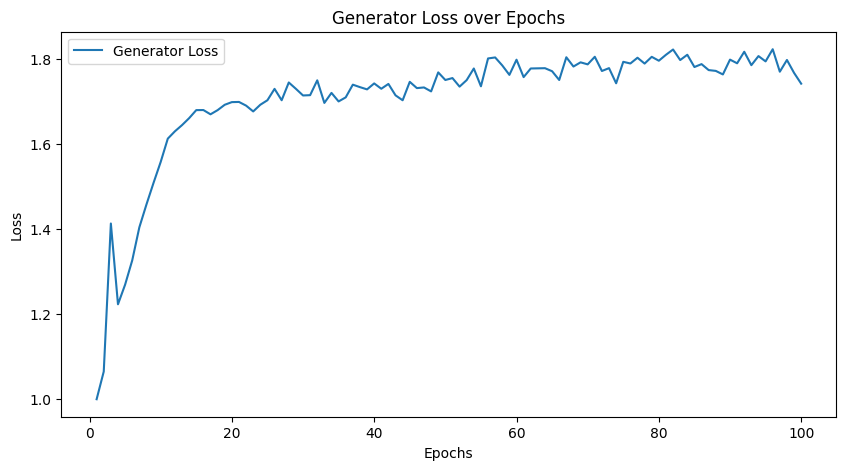

In [16]:
# Plot Generator Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(gen_loss_history) + 1), gen_loss_history, label='Generator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Generator Loss over Epochs')
plt.legend()
plt.show()

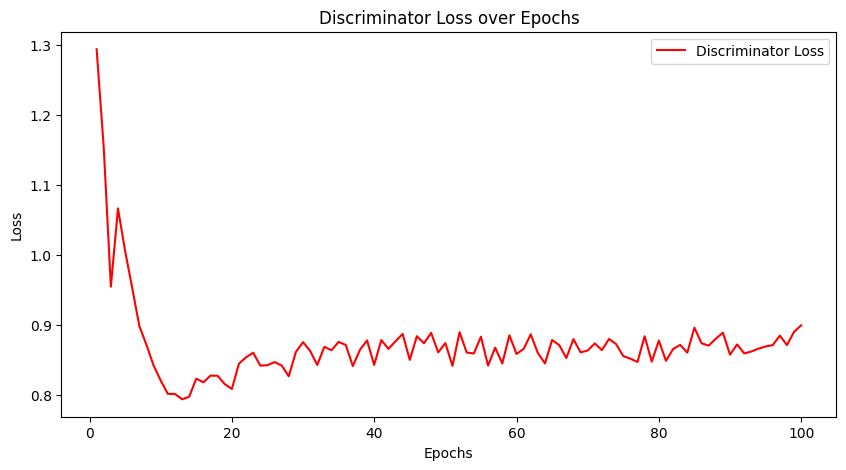

In [17]:
# Plot Discriminator Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(disc_loss_history) + 1), disc_loss_history, label='Discriminator Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Discriminator Loss over Epochs')
plt.legend()
plt.show()

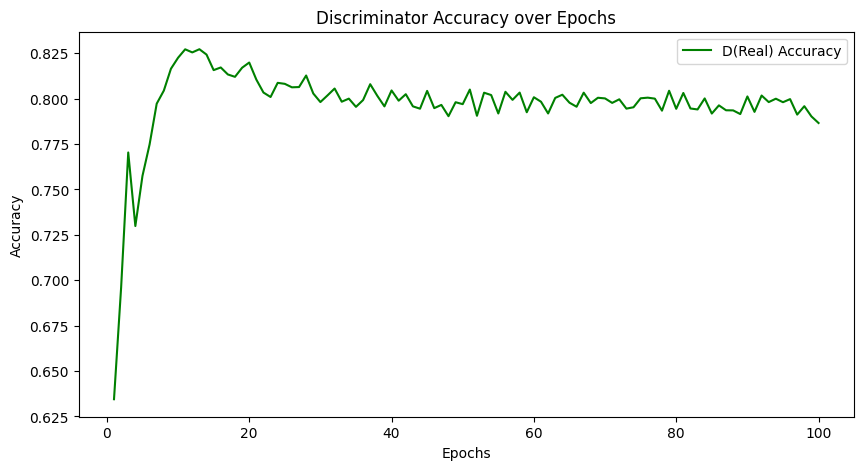

In [18]:
# Plot Discriminator Accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(real_acc_history) + 1), real_acc_history, label='D(Real) Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Discriminator Accuracy over Epochs')
plt.legend()
plt.show()


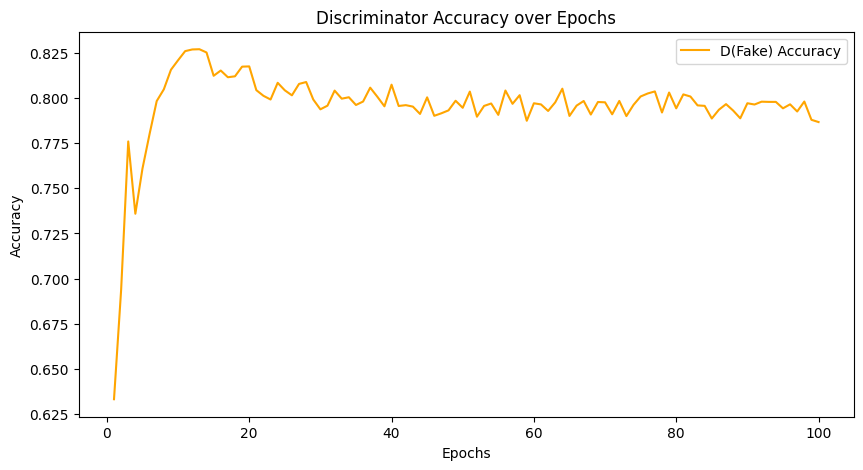

In [19]:
# Plot Discriminator Accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(fake_acc_history) + 1), fake_acc_history, label='D(Fake) Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Discriminator Accuracy over Epochs')
plt.legend()
plt.show()

## **FID**

In [20]:
# 1. Load InceptionV3 Model
# We use this pretrained model to extract features for FID calculation
inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))

# --- 2. Helper Functions (Robust & Fixed) ---
def scale_and_resize_images(images):
    """
    Resizes images to 299x299 and converts them to RGB.
    Input images should be in the range [0, 255].
    """
    images_list = []
    for img in images:
        # Convert numpy array to Tensor to avoid 'get_shape' errors
        img = tf.convert_to_tensor(img)

        # --- FIX: If image is 2D (H, W), add the channel dimension (H, W, 1) ---
        if len(img.shape) == 2:
            img = tf.expand_dims(img, axis=-1)

        # If image is grayscale (1 channel), convert to RGB (3 channels)
        if img.shape[-1] == 1:
            img = tf.image.grayscale_to_rgb(img)

        # Resize to 299x299 for InceptionV3
        img = tf.image.resize(img, [299, 299])
        images_list.append(img)

    # 'preprocess_input' handles the internal normalization for Inception
    return preprocess_input(np.array(images_list))

def calculate_fid(model, real_images, generated_images):
    # Resize and preprocess both sets
    real_images_resized = scale_and_resize_images(real_images)
    gen_images_resized = scale_and_resize_images(generated_images)

    # Extract features
    act1 = model.predict(real_images_resized, verbose=0)
    act2 = model.predict(gen_images_resized, verbose=0)

    # Calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)

    # Calculate squared difference of means
    ssdiff = np.sum((mu1 - mu2)**2.0)

    # Calculate sqrt of product of covariances
    covmean = sqrtm(sigma1.dot(sigma2))

    # Handle numerical instability (complex numbers)
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    # Final FID formula
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

# 3. Prepare Data

# A) Real Images (MNIST)
print("Loading real images...")
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()

# IMPORTANT: We keep data in [0, 255] range. We do NOT divide by 127.5 here.
train_images = train_images.astype('float32')

# Select 5000 random real images for better statistical accuracy
random_indices = np.random.randint(0, train_images.shape[0], 200)
real_batch = train_images[random_indices]

# B) Generated Images
print("Generating fake images...")
# Define NOISE_DIM if not already defined in your notebook
if 'NOISE_DIM' not in globals():
    NOISE_DIM = 100

noise = tf.random.normal([200, NOISE_DIM])
gen_batch = generator(noise, training=False)

# IMPORTANT: Generator output is [-1, 1]. We must convert it back to [0, 255].
gen_batch = (gen_batch * 127.5) + 127.5

# --- 4. Calculate FID ---
print("Calculating FID (This may take a minute due to resizing)...")
fid_score = calculate_fid(inception_model, real_batch, gen_batch)

print("-" * 30)
print(f"Final FID Score: {fid_score:.4f}")
print("-" * 30)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Loading real images...
Generating fake images...
Calculating FID (This may take a minute due to resizing)...
------------------------------
Final FID Score: 45.8627
------------------------------


# **ConvVAE**

## **Loading dataset**

In [21]:
# LOAD AND PREPROCESS DATA
print("Loading MNIST data...")
(x_train,_), (x_test, _) = tf.keras.datasets.mnist.load_data()

# Normalize to [0,1]
x_train = x_train.astype("float32") / 255.
x_test = x_test.astype("float32") / 255.

# Add channel dimension
x_train = np.expand_dims(x_train, -1)  # (60000,28,28,1)
#x_test = np.expand_dims(x_test, -1)

print(x_train.shape)

Loading MNIST data...
(60000, 28, 28, 1)


## **Encoder**

In [22]:
latent_dim = 16

# Reparameterization trick
def sampling(args):
    mean, logvar = args
    eps = tf.random.normal(shape=tf.shape(mean))
    return mean + tf.exp(0.5 * logvar) * eps

def make_encoder_model(latent_dim):

    # ---- Sequential backbone (exact style you asked) ----
    model = tf.keras.Sequential(name="encoder_backbone")

    # Input: 28x28x1 image
    model.add(layers.Input(shape=(28, 28, 1)))

    # Conv blocks (same params as your code)
    model.add(layers.Conv2D(32, 3, activation="relu",
                            strides=2, padding="same"))
    model.add(layers.Conv2D(64, 3, activation="relu",
                            strides=2, padding="same"))
    model.add(layers.Conv2D(128, 3, activation="relu",
                            strides=1, padding="same"))

    # Flatten + dense (same as your code)
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation="relu"))

    # ---- Functional part for multiple VAE outputs ----
    encoder_inputs = layers.Input(shape=(28, 28, 1), name="encoder_input")
    x = model(encoder_inputs)   # pass input through the Sequential backbone

    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = layers.Lambda(sampling, name="z")([z_mean, z_log_var])

    encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
    encoder.summary()
    return encoder

# build the encoder
encoder = make_encoder_model(latent_dim)


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_backbone    │ (None, 256)       │  1,698,560 │ encoder_input[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 16)        │      4,112 │ encoder_backbone… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 16)        │      4,112 │ encoder_backbone… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z (Lambda)          │ (None, 16)        │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,706,784 (6.51 MB)

 Trainable params: 1,706,784 (6.51 MB)

 Non-trainable params: 0 (0.00 B)

## **Decoder**

In [23]:
latent_dim = 16

# ---------------- DECODER WITH Sequential ----------------
def make_decoder_model(latent_dim):
    model = tf.keras.Sequential(name="decoder")

    # Input: latent vector (latent_dim,)
    model.add(layers.Input(shape=(latent_dim,)))

    # Dense + reshape (same as your code)
    model.add(layers.Dense(7 * 7 * 128, activation="relu"))
    model.add(layers.Reshape((7, 7, 128)))

    # Conv2DTranspose blocks (same params as your code)
    model.add(layers.Conv2DTranspose(128, 3, activation="relu",
                                     strides=1, padding="same"))
    model.add(layers.Conv2DTranspose(64, 3, activation="relu",
                                     strides=2, padding="same"))
    model.add(layers.Conv2DTranspose(32, 3, activation="relu",
                                     strides=2, padding="same"))

    # Output layer (same: 1 channel, sigmoid)
    model.add(layers.Conv2DTranspose(1, 3, activation="sigmoid",
                                     padding="same"))

    model.summary()
    return model

decoder = make_decoder_model(latent_dim)


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 6272)           │       106,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 7, 7, 128)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 14, 14, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 28, 28, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (None, 28, 28, 1)      │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 346,753 (1.32 MB)

 Trainable params: 346,753 (1.32 MB)

 Non-trainable params: 0 (0.00 B)

## **Vae**

In [24]:
class VAE(Model):
    def __init__(self, encoder, decoder, beta=2, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta

        self.total_loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.recon_loss_tracker = tf.keras.metrics.Mean(name="recon_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.recon_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        return self.decoder(z)

    def compute_losses(self, data):
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)

        # Reconstruction loss
        recon_loss = tf.reduce_mean(
            tf.keras.losses.binary_crossentropy(data, reconstruction)
        ) * 28 * 28

        # KL divergence
        kl_loss = -0.5 * tf.reduce_mean(
            1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
        )

        # Total β-VAE loss
        total_loss = recon_loss + self.beta * kl_loss
        return total_loss, recon_loss, kl_loss

    # ---- Training step ----
    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        with tf.GradientTape() as tape:
            total_loss, recon_loss, kl_loss = self.compute_losses(data)

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.recon_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "recon_loss": self.recon_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    # ---- Validation step ----
    def test_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        total_loss, recon_loss, kl_loss = self.compute_losses(data)

        self.total_loss_tracker.update_state(total_loss)
        self.recon_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "recon_loss": self.recon_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


## **Training**

In [25]:
# Define Adam optimizer with your desired hyperparameters
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001,beta_1=0.5)

vae = VAE(encoder, decoder, beta=2)
vae.compile(optimizer="adam")
history = vae.fit(x_train, epochs=100, batch_size=128, validation_split=0.1)

Epoch 1/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - kl_loss: 1.4254 - loss: 228.4868 - recon_loss: 225.6360 - val_kl_loss: 2.7136 - val_loss: 92.2878 - val_recon_loss: 86.8605
Epoch 2/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - kl_loss: 2.7605 - loss: 86.3871 - recon_loss: 80.8661 - val_kl_loss: 2.7980 - val_loss: 77.8705 - val_recon_loss: 72.2745
Epoch 3/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - kl_loss: 2.8364 - loss: 76.4512 - recon_loss: 70.7784 - val_kl_loss: 2.7983 - val_loss: 75.0125 - val_recon_loss: 69.4158
Epoch 4/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - kl_loss: 2.8486 - loss: 73.6139 - recon_loss: 67.9168 - val_kl_loss: 2.8177 - val_loss: 73.0986 - val_recon_loss: 67.4631
Epoch 5/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - kl_loss: 2.8598 - loss: 72.2048 - recon_loss: 66.4852 - val_kl_loss: 2.8414 - val_loss: 72.6371 - val_recon_loss: 66.9543
Epoch 6/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - kl_loss: 2.8614 - loss: 71.0250 - recon_loss: 65.30

## **Visualization of results**

In [26]:
# Extract loss values from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_recon_loss = history.history['recon_loss']
val_recon_loss = history.history['val_recon_loss']
train_kl_loss = history.history['kl_loss']
val_kl_loss = history.history['val_kl_loss']


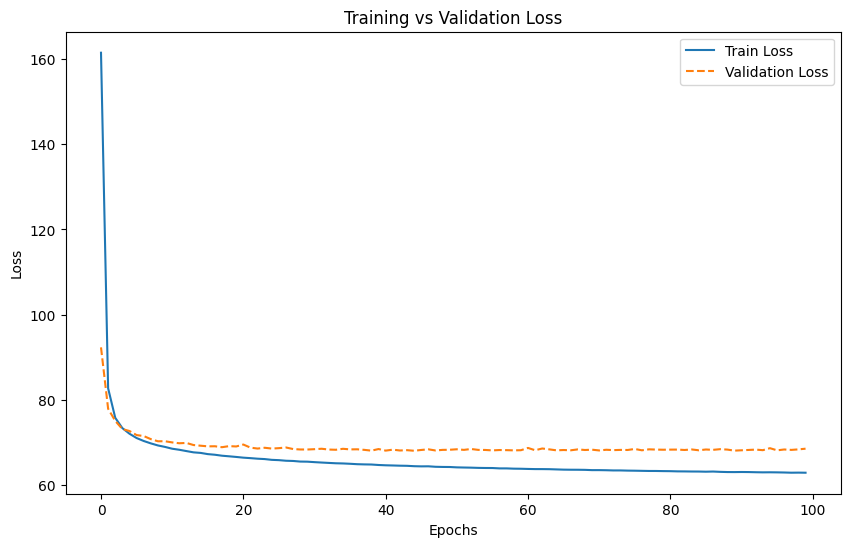

In [27]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Validation Loss", linestyle="--")
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


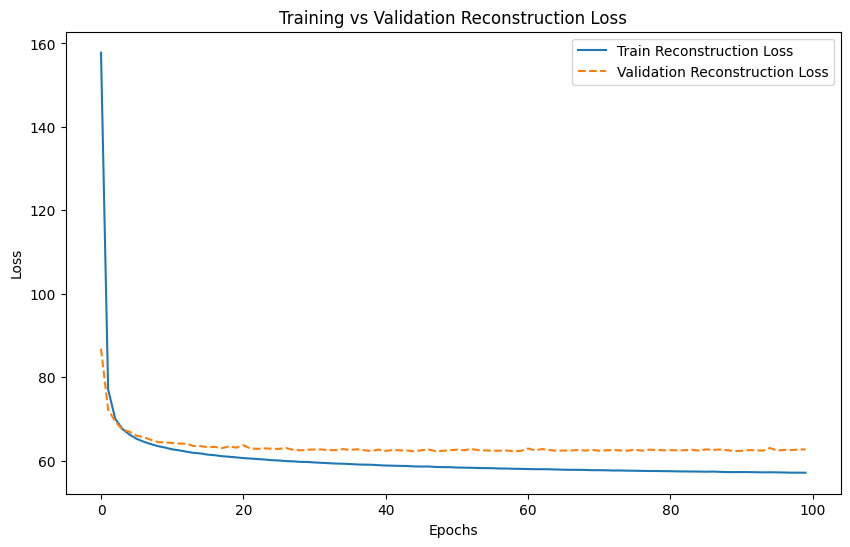

In [28]:
# Plot training and validation reconstruction loss
plt.figure(figsize=(10, 6))
plt.plot(train_recon_loss, label="Train Reconstruction Loss")
plt.plot(val_recon_loss, label="Validation Reconstruction Loss", linestyle="--")
plt.title("Training vs Validation Reconstruction Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


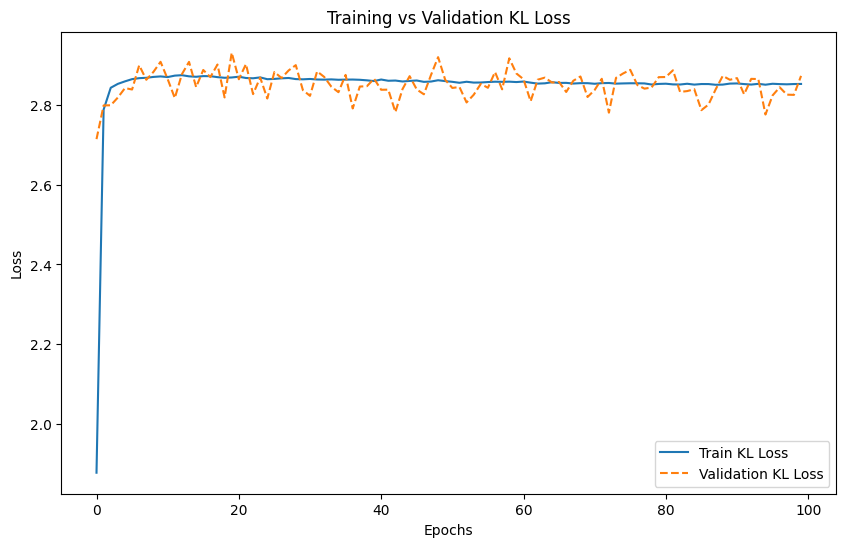

In [29]:
# Plot training and validation KL loss
plt.figure(figsize=(10, 6))
plt.plot(train_kl_loss, label="Train KL Loss")
plt.plot(val_kl_loss, label="Validation KL Loss", linestyle="--")
plt.title("Training vs Validation KL Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


## **Visualization of reconstruction**

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


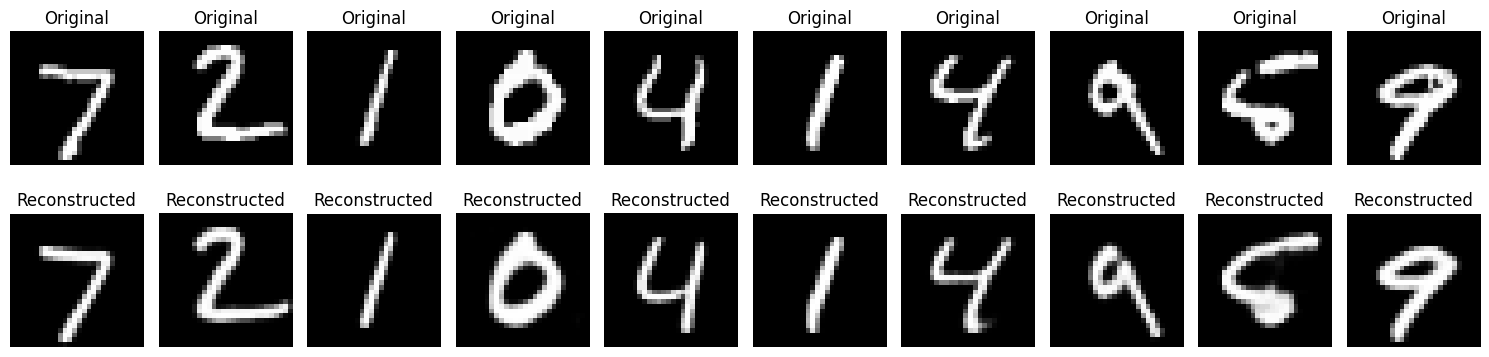

In [30]:
# Select 10 test images
x_sample = x_test[:10]
reconstructed = vae.predict(x_sample)

plt.figure(figsize=(15, 4))

for i in range(10):
    # Original
    ax = plt.subplot(2, 10, i + 1)
    plt.imshow(x_sample[i].squeeze(), cmap="gray")
    plt.title("Original")
    plt.axis("off")

    # Reconstruction
    ax = plt.subplot(2, 10, i + 11)
    plt.imshow(reconstructed[i].squeeze(), cmap="gray")
    plt.title("Reconstructed")
    plt.axis("off")

plt.tight_layout()
plt.show()


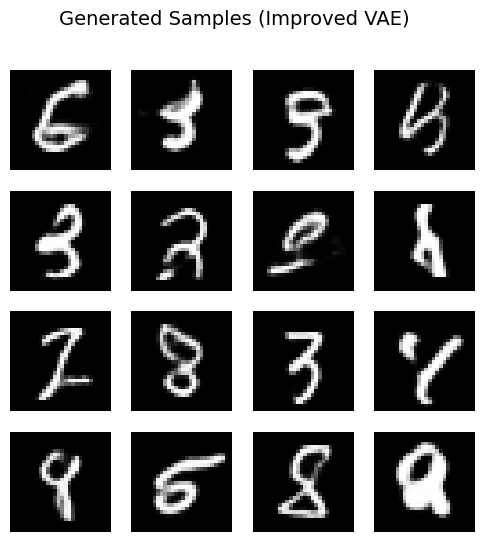

In [31]:
# Sample random z vectors
z_random = tf.random.normal(shape=(16, latent_dim))

# Generate images from decoder
generated = decoder(z_random)

plt.figure(figsize=(6, 6))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(generated[i].numpy().squeeze(), cmap="gray")
    plt.axis("off")

plt.suptitle("Generated Samples (Improved VAE)", fontsize=14)
plt.show()


## **FID**

In [32]:
# We use this pretrained model to extract features for FID calculation
inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))

# --- 2. Helper Functions ---
def scale_and_resize_images(images):
    """
    Resizes images to 299x299 and converts them to RGB.
    Input images should be in the range [0, 255].
    """
    images_list = []
    for img in images:
        # Convert numpy array to Tensor
        img = tf.convert_to_tensor(img)

        # If image is 2D (28, 28), add channel dim -> (28, 28, 1)
        if len(img.shape) == 2:
            img = tf.expand_dims(img, axis=-1)

        # If image is grayscale (1 channel), convert to RGB (3 channels)
        if img.shape[-1] == 1:
            img = tf.image.grayscale_to_rgb(img)

        # Resize to 299x299 for InceptionV3
        img = tf.image.resize(img, [299, 299])
        images_list.append(img)

    # 'preprocess_input' expects inputs [0, 255] for InceptionV3 default mode
    return preprocess_input(np.array(images_list))

def calculate_fid(model, real_images, generated_images):
    # Resize and preprocess both sets
    real_images_resized = scale_and_resize_images(real_images)
    gen_images_resized = scale_and_resize_images(generated_images)

    # Extract features
    act1 = model.predict(real_images_resized, verbose=0)
    act2 = model.predict(gen_images_resized, verbose=0)

    # Calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)

    # Calculate squared difference of means
    ssdiff = np.sum((mu1 - mu2)**2.0)

    # Calculate sqrt of product of covariances
    covmean = sqrtm(sigma1.dot(sigma2))

    # Handle numerical instability (complex numbers)
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    # Final FID formula
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

# --- 3. Prepare Data for VAE ---

# A) Real Images (MNIST)
# We use the test set here to see how well the VAE generalizes
print("Loading real images...")
(_, _), (x_test_fid, _) = tf.keras.datasets.mnist.load_data()

# Ensure float32 and range [0, 255]
x_test_fid = x_test_fid.astype('float32')

# Pick a random batch of real images
n_samples = 200
random_indices = np.random.randint(0, x_test_fid.shape[0], n_samples)
real_batch = x_test_fid[random_indices]

# B) Generated Images (VAE)
print("Generating VAE images...")

# 1. Sample from the latent space (Standard Normal Distribution)
# Your latent_dim was defined as 16 in your code
latent_dim = 16
random_latents = tf.random.normal(shape=(n_samples, latent_dim))

# 2. Decode the latents
# Note: Your decoder has a 'sigmoid' activation, so output is [0, 1]
gen_batch = decoder.predict(random_latents, verbose=0)

# 3. Scale back to [0, 255] for the FID function
gen_batch = gen_batch * 255.0

# --- 4. Calculate FID ---
print(f"Calculating FID on {n_samples} images (this takes a moment)...")
fid_score = calculate_fid(inception_model, real_batch, gen_batch)

print("-" * 30)
print(f"Final VAE FID Score: {fid_score:.4f}")
print("-" * 30)

Loading real images...
Generating VAE images...
Calculating FID on 200 images (this takes a moment)...


------------------------------
Final VAE FID Score: 60.5626
------------------------------
